# AGH Modelling of Physical Systems Lab 6 (2025 April 8th)
Jakub Kot

## Goal of the assignment
The goal of this assignment is to extend the Monte-Carlo advection code to two spatial dimensions. The code should define an initial condition in two dimensions and then be able to advect it using a constant-in-time flow field. Then the code should visualize and compare the results.

In [10]:
""" notebook code targetting 100% `nbqa pylint` score! :) """

import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import map_coordinates
from open_atmos_jupyter_utils import show_plot

In [11]:
NX, NY = 32, 32
x = np.linspace(0, 1, NX)
y = np.linspace(0, 1, NY)
dx = x[1] - x[0]
dy = y[1] - y[0]
X, Y = np.meshgrid(x, y, indexing='ij')

VELOCITY_X = 0.4
VELOCITY_Y = 1.2

In [12]:
def initialize_gaussian(center_x, center_y, width, grid_x, grid_y):
    """Create a Gaussian blob centered at (center_x, center_y)."""
    return np.exp(
        -(((grid_x - center_x) ** 2) + ((grid_y - center_y) ** 2))
        / (2 * width ** 2)
    )

In [13]:
def backtrack_coordinates(grid, velocity, dt, n_cells):
    """Compute backtracked coordinates for Monte-Carlo advection."""
    grid_x, grid_y = grid
    vel_x, vel_y = velocity
    n_cells_x, n_cells_y = n_cells

    backtracked_x = (grid_x - vel_x * dt) % 1.0
    backtracked_y = (grid_y - vel_y * dt) % 1.0

    coords = np.array([
        backtracked_x.flatten() * (n_cells_x - 1),
        backtracked_y.flatten() * (n_cells_y - 1)
    ])
    return coords


def monte_carlo_advect_2d(input_field, vel_x, vel_y, dt, samples=100):
    """Perform Monte-Carlo advection on a 2D field."""
    n_cells_x, n_cells_y = input_field.shape
    grid_space_x = np.linspace(0, 1, n_cells_x)
    grid_space_y = np.linspace(0, 1, n_cells_y)
    grid = np.meshgrid(grid_space_x, grid_space_y, indexing='ij')
    n_cells = (n_cells_x, n_cells_y)
    velocity = (vel_x, vel_y)

    advected = np.zeros_like(input_field)

    for _ in range(samples):
        coords = backtrack_coordinates(
            grid, velocity, dt, n_cells
        )
        sampled = map_coordinates(
            input_field,
            coords,
            order=1,
            mode='wrap'
        ).reshape((n_cells_x, n_cells_y))
        advected += sampled

    return advected / samples

In [14]:
TIME_STEP = 0.01
TOTAL_TIME = 1.0
NUM_STEPS = int(TOTAL_TIME / TIME_STEP)

In [15]:
initial_field = initialize_gaussian(0.5, 0.5, 0.1, X, Y)
field = initial_field.copy()

rmse_list = []
times = []

for step in range(NUM_STEPS):
    field = monte_carlo_advect_2d(field, VELOCITY_X, VELOCITY_Y, TIME_STEP)

    shifted_x = (X - VELOCITY_X * TIME_STEP * (step + 1)) % 1.0
    shifted_y = (Y - VELOCITY_Y * TIME_STEP * (step + 1)) % 1.0
    exact_field = initialize_gaussian(0.5, 0.5, 0.1, shifted_x, shifted_y)

    rmse = np.sqrt(np.mean((field - exact_field) ** 2))
    rmse_list.append(rmse)
    times.append((step + 1) * TIME_STEP)

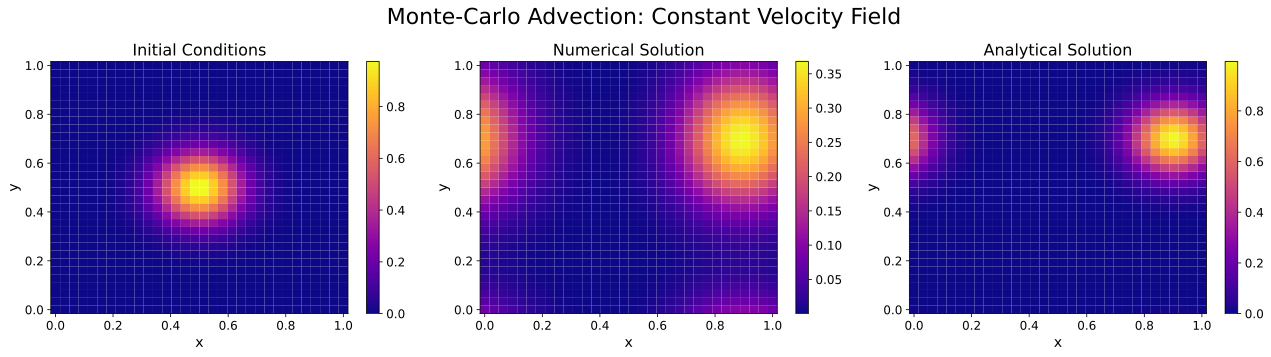

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

fields = [initial_field, field, exact_field]
titles = ['Initial Conditions', 'Numerical Solution', 'Analytical Solution']

for ax in axes:
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.tick_params(axis='both', which='minor', labelsize=12)

for ax, data, title in zip(axes, fields, titles):
    im = ax.pcolormesh(X, Y, data, cmap='plasma', shading='auto')
    fig.colorbar(im, ax=ax)
    ax.set_xlabel('x', fontsize=14)
    ax.set_ylabel('y', fontsize=14)
    ax.set_title(title, fontsize=16)
    im.colorbar.ax.tick_params(labelsize=12)

fig.suptitle('Monte-Carlo Advection: Constant Velocity Field', fontsize=22)
plt.tight_layout()
show_plot(filename="results")

## Result vs analytical solution

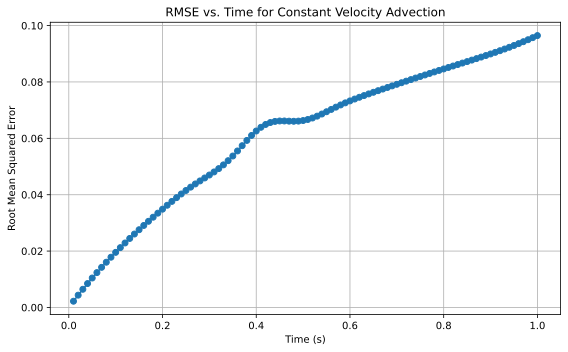

In [17]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(times, rmse_list, marker='o')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Root Mean Squared Error')
ax.set_title('RMSE vs. Time for Constant Velocity Advection')
ax.grid(True)
plt.tight_layout()
show_plot(filename="RMSE")

In [18]:
rmse_value = np.sqrt(np.mean((field - exact_field) ** 2))
print(f"RMSE: {rmse_value:.2e}")

RMSE: 9.65e-02


## Conclusions
The code was successfully extended to two dimensions. The code replicates the functionality of the original 1D code, but now operates in a 2D grid. Initial conditions are expressed as a 2D Gaussian distribution.

The advection process is performed using a constant velocity field, and the results are visualized using contour plots. The numerical solution is not exact, but it is close to the analytical solution.

The RMSE shows a gradual growth over time, which is expected due to the nature of the advection process and the cumulative error of the Monte-Carlo method. The RMSE is relatively small, indicating that the numerical method is performing well.

Also the `nbqa pylint` gives no errors:

![nbqa pylint](./pylint.png)

![cat](./cat.jpg)